In [1]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib



   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.8 MB 1.7 MB/s eta 0:00:28
   ---------------------------------------- 0.2/44.8 MB 2.8 MB/s eta 0:00:17
   ---------------------------------------- 0.4/44.8 MB 3.2 MB/s eta 0:00:14
    --------------------------------------- 0.7/44.8 MB 4.0 MB/s eta 0:00:12
   - -------------------------------------- 1.1/44.8 MB 5.1 MB/s eta 0:00:09
   - -------------------------------------- 1.6/44.8 MB 5.8 MB/s eta 0:00:08
   - -------------------------------------- 2.0/44.8 MB 6.4 MB/s eta 0:00:07
   -- ------------------------------------- 2.5/44.8 MB 6.9 MB/s eta 0:00:07
   -- ------------------------------------- 3.0/44.8 MB 7.3 MB/s eta 0:00:06
   --- ------------------------------------ 3.5/44.8 MB 7.7 MB/s eta 0:00:06
   --- ------------------------------------ 4.0/44.8 MB 8.0 MB/s eta 0:00:06
   ---- ----------------------------------- 4.5/44.8 MB 8.3 MB/s eta 0:00:05
   --

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from keras.models import load_model

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections


In [6]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [7]:
cap = cv2.VideoCapture(0)
# # Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
   while cap.isOpened():

      # Read feed
    ret, frame = cap.read()

#         # Make detections
    image, results = mediapipe_detection(frame, holistic)
    print(results)
        
#         # Draw landmarks
    draw_styled_landmarks(image, results)

#         # Show to screen
    cv2.imshow('OpenCV Feed', image)

#         # Break when type 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Data') 

# Actions that we try to detect
actions = np.array([ 'Xin_chao','Xin_loi','Cam_on'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 60

In [13]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [14]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
                    
cap.release()
cv2.destroyAllWindows()

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\heoti\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



     ---------------------------------------- 0.0/422.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/422.6 MB 1.4 MB/s eta 0:05:10
     ---------------------------------------- 0.1/422.6 MB 1.7 MB/s eta 0:04:03
     ---------------------------------------- 0.3/422.6 MB 2.3 MB/s eta 0:03:08
     ---------------------------------------- 0.5/422.6 MB 2.8 MB/s eta 0:02:30
     ---------------------------------------- 0.7/422.6 MB 3.3 MB/s eta 0:02:09
     ---------------------------------------- 0.9/422.6 MB 3.5 MB/s eta 0:02:02
     ---------------------------------------- 1.1/422.6 MB 3.6 MB/s eta 0:01:58
     ---------------------------------------- 1.3/422.6 MB 3.8 MB/s eta 0:01:52
     ---------------------------------------- 1.5/422.6 MB 3.8 MB/s eta 0:01:51
     ---------------------------------------- 1.7/422.6 MB 3.9 MB/s eta 0:01:47
     ---------------------------------------- 1.9/422.6 MB 3.9 MB/s eta 0:01:49
     ---------------------------------------- 2

In [15]:
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

In [16]:
label_map = {label:num for num, label in enumerate(actions)}

In [17]:
label_map

{'Xin_chao': 0, 'Xin_loi': 1, 'Cam_on': 2}

In [18]:
sequences, labels = [], [] #gán nhãn
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [19]:

print(actions.shape[0])

3


In [20]:
np.array(sequences).shape

(90, 60, 126)

In [21]:
np.array(labels).shape

(90,)

In [22]:
X = np.array(sequences)

In [23]:
X.shape

(90, 60, 126)

In [24]:
y = to_categorical(labels).astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #chia test

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
import tensorflow as tf

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,126))) # 64
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [29]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
3/3 [==============================] - 6s 98ms/step - loss: 1.0541 - categorical_accuracy: 0.4167
Epoch 2/100
3/3 [==============================] - 0s 75ms/step - loss: 0.8585 - categorical_accuracy: 0.6250
Epoch 3/100
3/3 [==============================] - 0s 79ms/step - loss: 0.7671 - categorical_accuracy: 0.7361
Epoch 4/100
3/3 [==============================] - 0s 80ms/step - loss: 0.6259 - categorical_accuracy: 0.9861
Epoch 5/100
3/3 [==============================] - 0s 142ms/step - loss: 0.5690 - categorical_accuracy: 0.9583
Epoch 6/100
3/3 [==============================] - 0s 136ms/step - loss: 1.0879 - categorical_accuracy: 0.8889
Epoch 7/100
3/3 [==============================] - 0s 140ms/step - loss: 0.4595 - categorical_accuracy: 0.9722
Epoch 8/100
3/3 [==============================] - 0s 84ms/step - loss: 7.3098 - categorical_accuracy: 0.9306
Epoch 9/100
3/3 [==============================] - 0s 79ms/step - loss: 1.0247 - categorical_accuracy: 0.7639
Epoch 1

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 203459 (794.76 KB)
Trainable params: 20345

In [32]:
model.save('begin1.h5')

c:\Users\heoti\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
model.load_weights('begin1.h5')

In [60]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [61]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 84ms/step


In [62]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [63]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[11,  0],
        [ 0,  7]],

       [[14,  0],
        [ 0,  4]],

       [[11,  0],
        [ 0,  7]]], dtype=int64)

In [64]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ytrue, yhat)
print('Confusion matrix:')
print(cnf_matrix)

Confusion matrix:
[[7 0 0]
 [0 4 0]
 [0 0 7]]


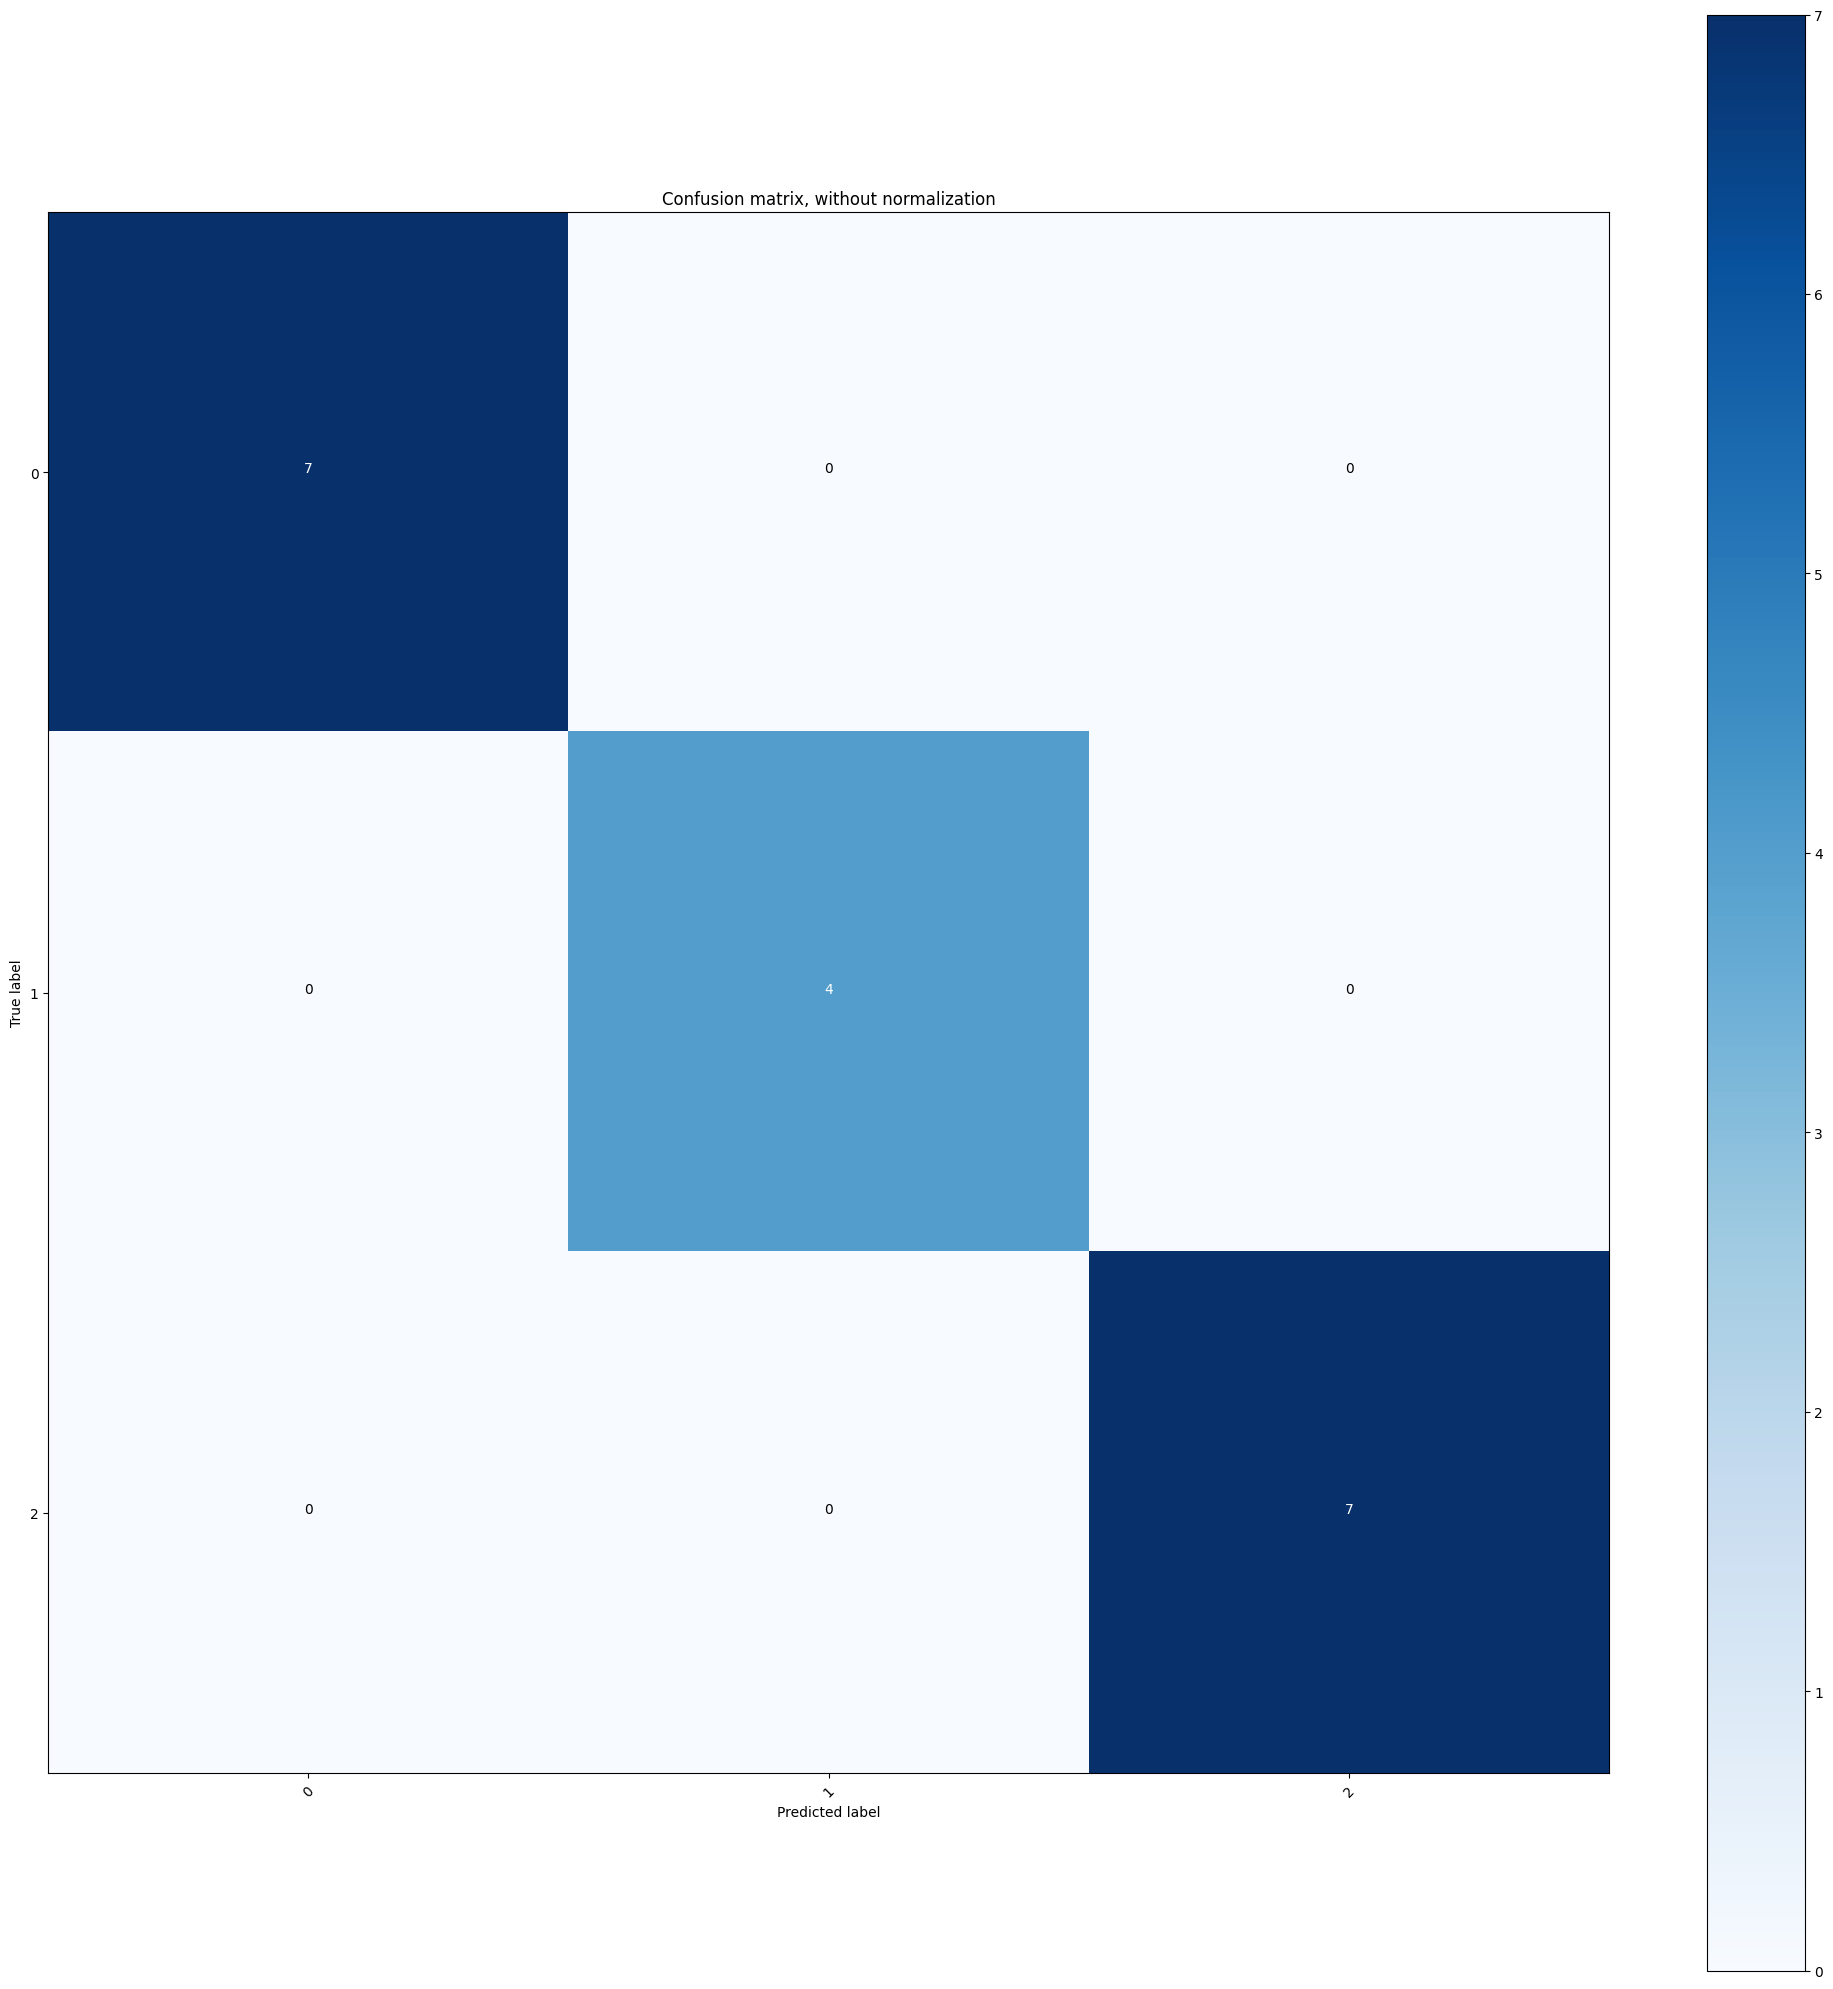

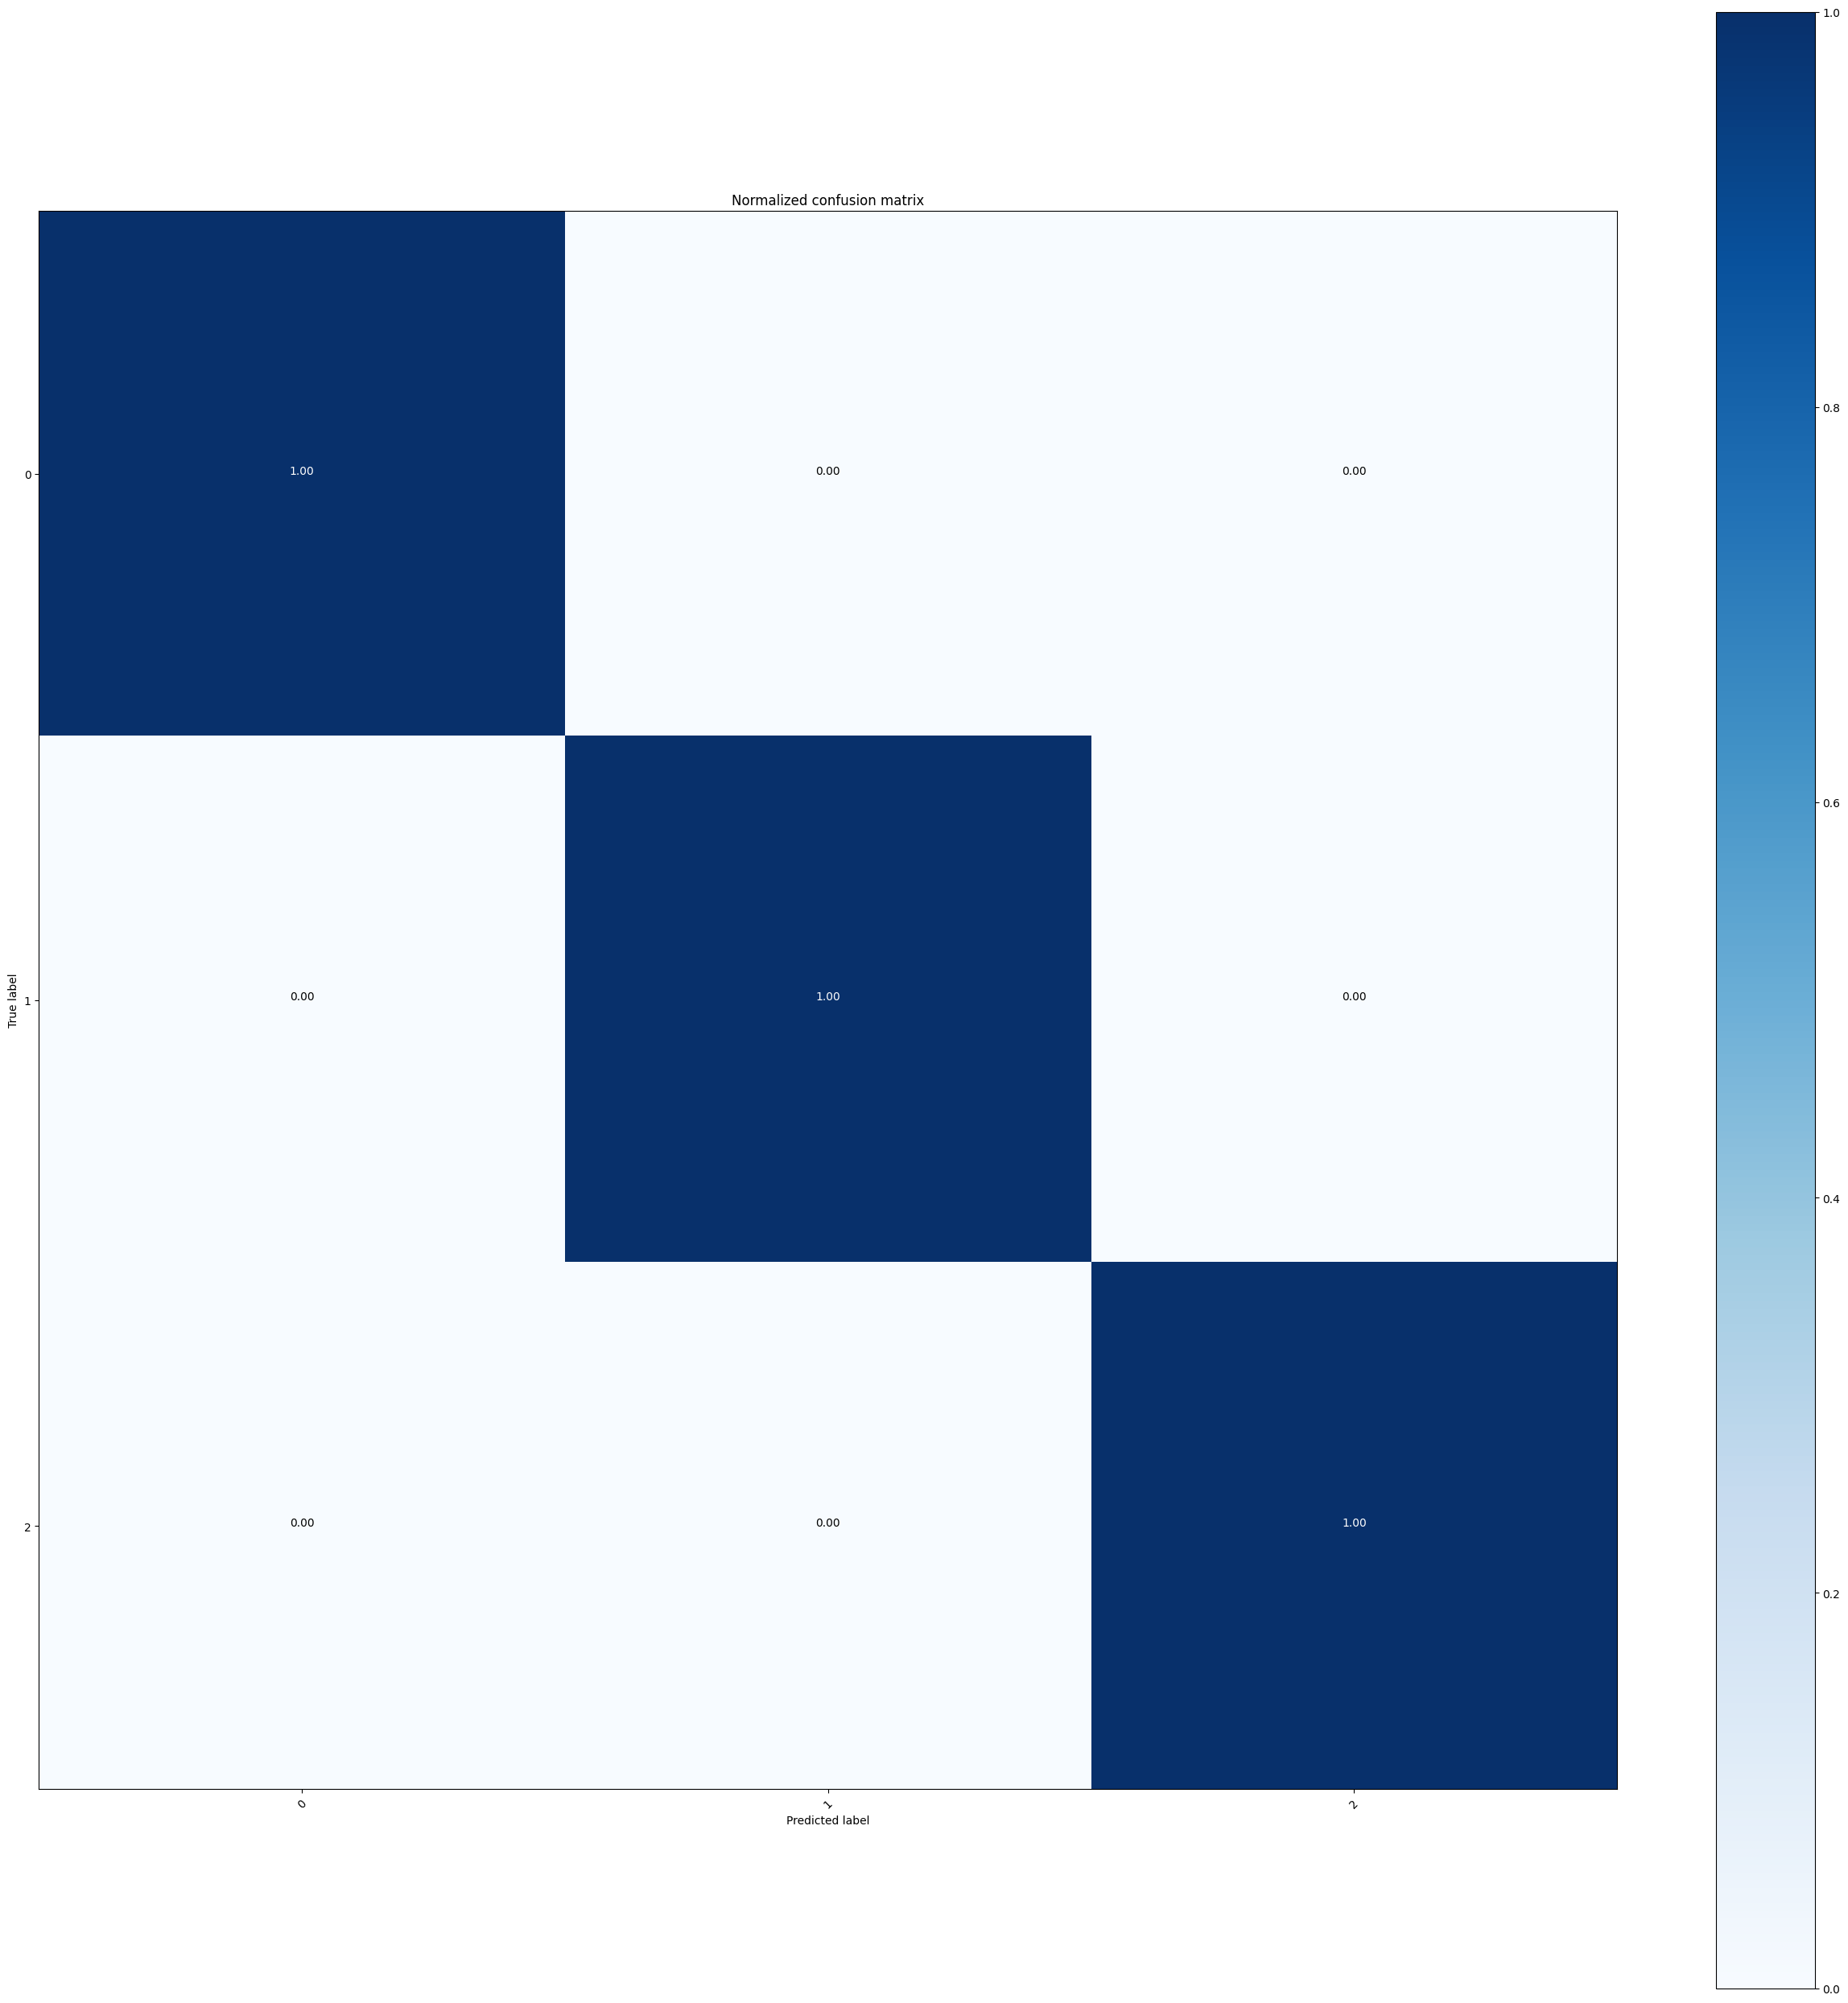

In [65]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2]
plt.figure(figsize = (20, 20))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (25, 25))
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [40]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [41]:
import time

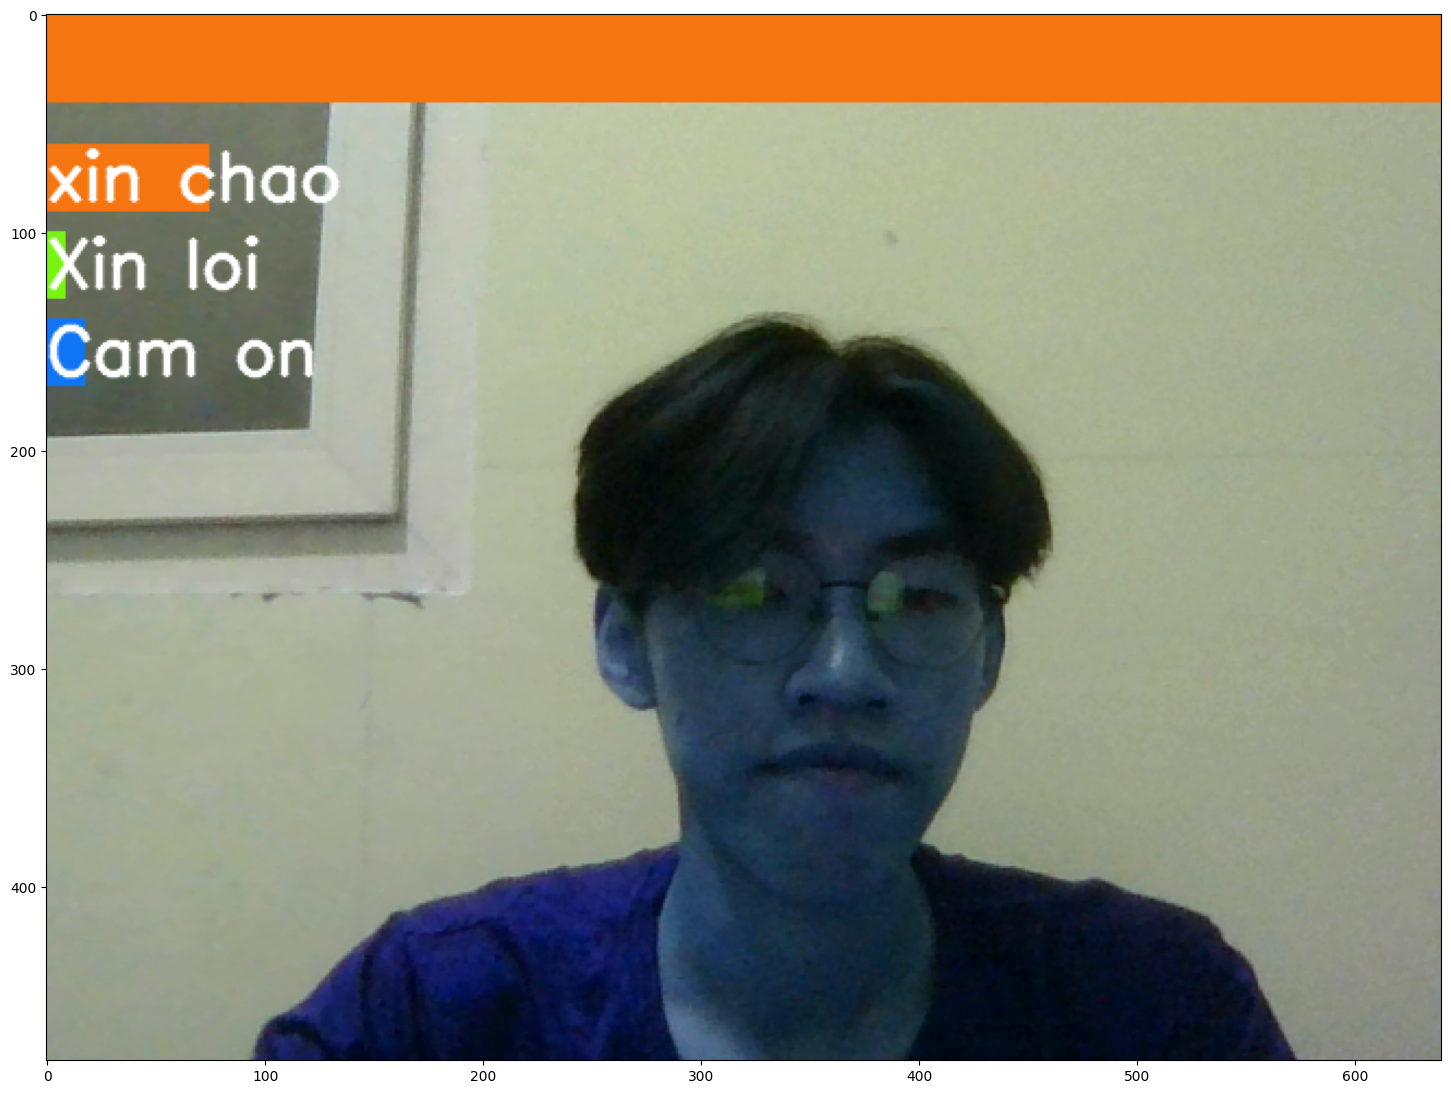

In [51]:

plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [58]:
sequence.reverse()

In [57]:
len(sequence)

61

In [56]:
sequence.append('def')

In [54]:
sequence.reverse()

In [55]:
sequence[-30:]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [72]:
import cv2   
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0) 
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() # đọc video từ camera

        # Make detections
        image, results = mediapipe_detection(frame, holistic) # gọi biến image và result = giá trị RGB của ảnh
        print(results)
        
        # Draw landmarks
       # nhận diện cơ thể 
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results) # xuất ra array các keypoints cơ thể (mấy cái đốt í)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-60:] # Đưa các frame thu đc vào mảng sequence, ở đây t để là 30 frame cuối
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)]) # Nếu thu đủ số frame của câu, đưa các array đấy vào model rồi ước lượng ra kết quả chính xác nhất trong dữ liệu
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 0: 
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('NHAN DANG NGON NGU KY HIEU', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 203459 (794.76 KB)
Trainable params: 20345

In [68]:
res[np.argmax(res)] > threshold

False

In [69]:
model.predict(np.expand_dims(X_test[0], axis=0))

KeyboardInterrupt: 

In [81]:
import tensorflow as tf
keras_model = load_model ('begin.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
# converter.optimizations = [tf.lite.Optimize.DEFAULT] # sử dụng optimization nếu cần tối ưu thêm
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\heoti\AppData\Local\Temp\tmplrhkxvaw\assets


INFO:tensorflow:Assets written to: C:\Users\heoti\AppData\Local\Temp\tmplrhkxvaw\assets
